In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)

from sklearn.inspection import partial_dependence



import sklearn.model_selection as cv
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import plot_partial_dependence

## *EDA*

In [2]:
# Load dataframe containing individual games

game_df = pd.read_csv('data/game.csv')
game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,2,4,home win REG,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,3,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,2018030413,20182019,P,2019-06-02,2019-06-02T00:00:00Z,6,19,7,2,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT
11430,2018030414,20182019,P,2019-06-04,2019-06-04T00:00:00Z,6,19,2,4,home win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT
11431,2018030415,20182019,P,2019-06-07,2019-06-07T00:00:00Z,19,6,2,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-4,EDT
11432,2018030416,20182019,P,2019-06-10,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-5,CDT


In [3]:
# Add column goal spread per game and calculate the average
# Do the same for total goals per game

game_df['goal_spread'] = abs(game_df['away_goals'] - game_df['home_goals'])
print('Average goal spread: ', game_df['goal_spread'].mean())

game_df['total_goals'] = game_df['away_goals'] + game_df['home_goals']
print('Average goals per game: ', game_df['total_goals'].mean())

In [7]:
# Adjust win/loss column based on home team

game_df.loc[game_df['outcome'].str.contains('home'), 'outcome'] = 'win'
game_df.loc[game_df['outcome'].str.contains('away'), 'outcome'] = 'loss'

In [8]:
# Load dataframe containing team info
# This might be useful for finding out specific team names but won't be used for now.

team_df = pd.read_csv('data/team_info.csv')
team_df.head(6)

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6
5,3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3


In [9]:
# How to locate team names based on team_id

team_df[team_df['team_id'] == 5]

,team_id,franchiseId,shortName,teamName,abbreviation,link
6,5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5


### Compile cumulative statistics up to current game

In [10]:
# Load dataframe of game outcomes grouped by teams
# Each row is one game for one team.

team_game_df = pd.read_csv('data/game_teams_stats.csv')

# Look at games for team 1

team_game_df.loc[team_game_df.team_id == 1]

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
5,2011030223,1,home,True,OT,Peter DeBoer,4,31,30,10,2,1,49.2,11,4
7,2011030224,1,home,True,REG,Peter DeBoer,4,43,19,4,5,1,37.5,5,3
8,2011030225,1,away,True,REG,Peter DeBoer,3,30,26,2,4,1,55.0,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22548,2018021199,1,away,False,REG,John Hynes,0,28,44,2,1,0,47.1,13,5
22567,2018021207,1,home,False,OT,John Hynes,2,27,20,2,3,1,47.8,11,10
22595,2018021222,1,home,True,REG,John Hynes,4,41,23,21,4,1,66.7,10,5
22644,2018021247,1,away,False,REG,John Hynes,1,37,30,4,3,0,50.0,7,10


In [11]:
# Create column showing previous game's outcome

team_game_df['streak'] = team_game_df.groupby('team_id')['won'].shift(fill_value=0)

# Replace 0s in the 'streak' column with False due a team not having a previous game in the dataset

team_game_df = team_game_df.replace({'streak': 0}, False)
team_game_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,0
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,0
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,False
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,True
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,False


In [13]:
# Create column with time zones traveled information between games

df = pd.merge(team_game_df, game_df[['game_id','venue_time_zone_offset']],on='game_id', how='left')
df['prev_time'] = df.groupby('team_id')['venue_time_zone_offset'].shift(fill_value=0)
df['time_travel'] = abs(df['prev_time'] - df['venue_time_zone_offset'])

# Replace any values greater than 3 with 0 due to no previous game in the dateset

df['time_travel'] = df['time_travel'].apply(lambda x: 0 if abs(x) > 3 else x)
df.tail(5)

# Replace bools with 1, 0

df = df.replace({'won': False}, 0)
df = df.replace({'won': True}, 1)
df = df.replace({'streak': False}, 0)
df = df.replace({'streak': True}, 1)
df = df.replace({'HoA': 'away'}, 0)
df = df.replace({'HoA': 'home'}, 1)

### Look at total wins/losses to see if teams jump out as particularly good or bad

In [17]:
# Total wins for each team
df['team_id'].value_counts()

328.0

In [20]:
# wins/losses/winning % per team_id

team_ids = list(df['team_id'].unique())
team_ids = sorted(team_ids)

team_win_loss = {}
for team in team_ids:
    w = df[df['team_id'] == team]['won'].sum()
    l = df['team_id'].value_counts()[team] - w
    per = w / (w + l)
    team_win_loss[team] = (w, l, per)
    
# Looks like team 5 has the most wins
print(team_win_loss)
print('Team 5: ', team_df[team_df['team_id'] == 5])

### Continue compiling and organize cumulative stats

In [22]:
# Make a copy of df, which contains game stats grouped by teams

df_pregame = df
df_pregame.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,streak,venue_time_zone_offset,prev_time,time_travel
0,2011030221,1,0,0.0,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7,0.0,-4,0,0
1,2011030221,4,1,1.0,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4,0.0,-4,0,0
2,2011030222,1,0,1.0,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7,0.0,-4,-4,0
3,2011030222,4,1,0.0,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6,1.0,-4,-4,0
4,2011030223,4,0,0.0,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1,0.0,-4,-4,0


In [23]:
# Cumulative stats in the copied dataframe

df_pregame['gpg'] = (df_pregame.groupby('team_id')['goals'].cumsum() - df_pregame['goals']) / df_pregame.groupby('team_id').cumcount()
df_pregame['win_per'] = (df_pregame.groupby('team_id')['won'].cumsum() - df_pregame['won']) / df_pregame.groupby('team_id').cumcount()
df_pregame['shots_pg'] = (df_pregame.groupby('team_id')['shots'].cumsum() - df_pregame['shots']) / df_pregame.groupby('team_id').cumcount()
df_pregame['hits_pg'] = (df_pregame.groupby('team_id')['hits'].cumsum() - df_pregame['hits']) / df_pregame.groupby('team_id').cumcount()
df_pregame['pim_pg'] = (df_pregame.groupby('team_id')['pim'].cumsum() - df_pregame['pim']) / df_pregame.groupby('team_id').cumcount()
df_pregame['hits_pg'] = (df_pregame.groupby('team_id')['hits'].cumsum() - df_pregame['hits']) / df_pregame.groupby('team_id').cumcount()
df_pregame['fo_per'] = (df_pregame.groupby('team_id')['faceOffWinPercentage'].cumsum() - df_pregame['faceOffWinPercentage']) / df_pregame.groupby('team_id').cumcount()
df_pregame['giveaways_pg'] = (df_pregame.groupby('team_id')['giveaways'].cumsum() - df_pregame['giveaways']) / df_pregame.groupby('team_id').cumcount()
df_pregame['takeaways_pg'] = (df_pregame.groupby('team_id')['takeaways'].cumsum() - df_pregame['takeaways']) / df_pregame.groupby('team_id').cumcount()
df_pregame['ppg_per'] = ((df_pregame.groupby('team_id')['powerPlayGoals'].cumsum() - df_pregame['powerPlayGoals'])) / ((df_pregame.groupby('team_id')['powerPlayOpportunities'].cumsum() - df_pregame['powerPlayOpportunities']))

df_pregame

In [26]:
# Create copy of the game dataframe to begin comparing team stats head-to-head for each game

test_game_df = game_df

# Drop unnecessary columns

test_game_df.drop(labels=['home_rink_side_start', 'venue', 'venue_link', 'venue_time_zone_id', 'venue_time_zone_tz'], axis=1, inplace=True)
test_game_df.drop(labels=['away_goals', 'home_goals', 'venue_time_zone_offset'], axis=1, inplace=True)
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4


In [28]:
# Filter and merge home team pregame stats into games dataframe

filtered = df_pregame[df_pregame.HoA == 1]
filtered = filtered.filter(items=['game_id', 'streak', 'time_travel', 'home_gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])

test_game_df = test_game_df.merge(filtered, on='game_id', how='left')
test_game_df = test_game_df.rename(columns={'gpg': 'home_gpg', 'streak': 'home_streak', 'time_travel': 'home_time_travel', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
test_game_df.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,outcome,goal_spread,total_goals,...,home_time_travel,home_gpg,home_win_per,home_ppg_per,home_shots_pg,home_hits_pg,home_pim_pg,home_fo_per,home_giveaways_pg,home_takeaways_pg
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,win,1,7,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,loss,3,5,...,0,4.000000,1.000000,0.166667,36.000000,27.0,6.000000,55.100000,13.000000,4.0
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,win,1,7,...,0,3.500000,0.500000,0.142857,30.500000,31.5,12.000000,47.900000,7.000000,7.0
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,win,2,6,...,0,3.666667,0.666667,0.222222,30.666667,31.0,11.333333,48.333333,8.333333,6.0
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,loss,2,4,...,0,2.500000,0.250000,0.166667,26.500000,25.5,13.000000,54.375000,11.000000,4.0


In [29]:
# Filter and merge away team pregame stats

filtered = df_pregame[df_pregame.HoA == 0]
filtered = filtered.filter(items=['game_id', 'streak', 'time_travel', 'home_gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])

test_game_df = test_game_df.merge(filtered, on='game_id', how='left')
test_game_df = test_game_df.rename(columns={'gpg': 'away_gpg', 'streak': 'away_streak', 'time_travel': 'away_time_travel',"win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})
test_game_df.head()

,game_id,streak,time_travel,away_gpg,win_per,ppg_per,shots_pg,hits_pg,pim_pg,fo_per,giveaways_pg,takeaways_pg
0,2011030221,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011030222,0.0,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
4,2011030223,0.0,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
6,2011030224,0.0,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
8,2011030225,1.0,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


In [31]:
# new working df with pregame stats for home and away to allow for head to head comparisons.

# Fill NaN with 0

test_game_df = test_game_df.fillna(0)

# Look at columns and the new df
print(test_game_df.columns)
test_game_df.head()

In [33]:
# Finalize the dataframe (model_df) to be used for initial modeling

model_df = test_game_df.drop(labels=['game_id', 'season', 'type', 'date_time','date_time_GMT'], axis=1)
print(model_df.columns)
model_df.head()

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_time_travel,home_gpg,home_win_per,home_ppg_per,...,away_time_travel,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,1,4,win,1,7,0.0,0,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000
1,1,4,loss,3,5,1.0,0,4.000000,1.000000,0.166667,...,0,3.000000,0.000000,0.333333,26.00,31.000000,12.0,44.900000,6.0,7.000000
2,4,1,win,1,7,1.0,0,3.500000,0.500000,0.142857,...,0,2.500000,0.500000,0.090909,28.00,25.500000,19.0,52.100000,11.0,5.000000
3,4,1,win,2,6,1.0,0,3.666667,0.666667,0.222222,...,0,2.666667,0.333333,0.125000,28.00,26.333333,14.0,51.666667,8.0,3.666667
4,1,4,loss,2,4,0.0,0,2.500000,0.250000,0.166667,...,0,3.750000,0.750000,0.214286,33.75,28.000000,9.5,45.625000,7.5,5.250000


### **Initial logistic regression**

My initial models below all had ~55% accuracy.  Eliminated some features based on p-values and
dependence plots.  My target is ~60% so the next step is to breakdown team stats by season since
teams change from year to year.

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [ ]:
X = model_df.drop(labels=['outcome'], axis=1)
y = model_df.outcome

In [37]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)

In [38]:
model = LogisticRegression(C=1000)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000)

In [39]:
# Look at betas for each feature

coefs = []
for i in model.coef_:
    for coef in i:
        coefs.append(coef)

betas = {k: v for k, v in zip(list(X.columns), coefs)}
betas

{'away_team_id': 0.0024483241139516237,
 'home_team_id': -0.0002123379155126861,
 'goal_spread': 0.11778838271147228,
 'total_goals': 0.013019577348397223,
 'home_streak': -0.04782089532991535,
 'home_time_travel': 0.0190907261213392,
 'home_gpg': 0.39936093206214096,
 'home_win_per': 0.15736157763683936,
 'home_ppg_per': 0.0398070527806266,
 'home_shots_pg': 0.016065334911097517,
 'home_hits_pg': 0.0022031429069358744,
 'home_pim_pg': -0.025743741272660665,
 'home_fo_per': 0.001738253698391103,
 'home_giveaways_pg': -0.0038693748182243295,
 'home_takeaways_pg': -0.031868382921486166,
 'away_streak': 0.04600526091668979,
 'away_time_travel': -0.0008062300799518117,
 'away_gpg': -0.3931470014804633,
 'away_win_per': -0.15590151083575682,
 'away_ppg_per': -0.03263389133153694,
 'away_shots_pg': -0.0416356634103675,
 'away_hits_pg': -0.0019002757876353685,
 'away_pim_pg': 0.03713117244567162,
 'away_fo_per': 0.0035227028533132304,
 'away_giveaways_pg': 0.022240654311177666,
 'away_takeawa

In [40]:
# Drop time travel for home and away teams due to very low beta

df_nott = model_df.drop(labels=['home_time_travel', 'away_time_travel'], axis=1)

In [41]:
# Train, test, split the new dataframes

X2 = df_nott.drop(labels=['outcome'], axis=1)
y2 = df_nott.outcome

y2 = y2.apply(lambda x: 1 if x == 'win' else 0)

X2_train, X2_test, y2_train, y2_test = cv.train_test_split(X2, y2, test_size=0.25, random_state=1)

In [44]:
# Train a new logistic regression model

model2 = LogisticRegression(C=1000)
model2.fit(X2_train, y2_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000)

In [45]:
# Look at the new betas without time travel features

coefs2 = []
for i in model2.coef_:
    for coef in i:
        coefs2.append(coef)

betas2 = {k: v for k, v in zip(list(X2.columns), coefs)}
betas2

{'away_team_id': 0.0024483241139516237,
 'home_team_id': -0.0002123379155126861,
 'goal_spread': 0.11778838271147228,
 'total_goals': 0.013019577348397223,
 'home_streak': -0.04782089532991535,
 'home_gpg': 0.0190907261213392,
 'home_win_per': 0.39936093206214096,
 'home_ppg_per': 0.15736157763683936,
 'home_shots_pg': 0.0398070527806266,
 'home_hits_pg': 0.016065334911097517,
 'home_pim_pg': 0.0022031429069358744,
 'home_fo_per': -0.025743741272660665,
 'home_giveaways_pg': 0.001738253698391103,
 'home_takeaways_pg': -0.0038693748182243295,
 'away_streak': -0.031868382921486166,
 'away_gpg': 0.04600526091668979,
 'away_win_per': -0.0008062300799518117,
 'away_ppg_per': -0.3931470014804633,
 'away_shots_pg': -0.15590151083575682,
 'away_hits_pg': -0.03263389133153694,
 'away_pim_pg': -0.0416356634103675,
 'away_fo_per': -0.0019002757876353685,
 'away_giveaways_pg': 0.03713117244567162,
 'away_takeaways_pg': 0.0035227028533132304}

In [46]:
# Perform k-fold cross validation on data with no time travel

kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
logr_scores = []

model_kf = LogisticRegression()
    
for train, test in kf.split(X2):
    ## fit the model to training data
    model_kf.fit(X2.values[train], y2.values[train])
    ## evaluate the model on testing data!!!
    logr_scores.append(model_kf.score(X2.values[test], y2.values[test]))
    
print(np.mean(logr_scores))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

0.5529115266363458


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
# Calculate p-values for the features

from scipy.stats import norm

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

logit_pvalue(model_kf, X2)

pvals = {}
for feat, pval in zip(list(X2.columns), logit_pvalue(model_kf, X2)):
    pvals[feat] = pval
    
# Compare betas and p-values

print(betas2)
pvals

In [49]:
# Perform lasso regression

from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X2_train, y2_train)

reg.score(X2_test, y2_test)

-0.002118741157018489

##### **Logistic regression using only features with low p-values**

In [50]:
#  Create a new dataframe with fewer features based on p-values

new_feats = ['home_win_per', 'home_hits_pg', 'home_fo_per', 'away_streak', 'away_gpg', 'away_win_per', 'away_hits_pg', 'away_fo_per']
new_df = X2[new_feats]
new_df

,home_win_per,home_hits_pg,home_fo_per,away_streak,away_gpg,away_win_per,away_hits_pg,away_fo_per
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1.000000,27.000000,55.100000,0.0,3.000000,0.000000,31.000000,44.900000
2,0.500000,31.500000,47.900000,0.0,2.500000,0.500000,25.500000,52.100000
3,0.666667,31.000000,48.333333,0.0,2.666667,0.333333,26.333333,51.666667
4,0.250000,25.500000,54.375000,1.0,3.750000,0.750000,28.000000,45.625000
...,...,...,...,...,...,...,...,...
11429,0.564496,23.432950,50.738186,0.0,2.971499,0.573730,24.770756,52.438290
11430,0.563776,23.447704,50.730102,1.0,2.976485,0.574257,24.775990,52.442203
11431,0.573548,24.796044,52.436341,1.0,2.761783,0.564331,23.473885,50.732102
11432,0.564885,23.487277,50.743130,0.0,2.972840,0.572840,24.818519,52.421728


In [51]:
X3_train, X3_test, y3_train, y3_test = cv.train_test_split(new_df, y2, test_size=0.25, random_state=1)

In [52]:
# Create a new model

model3 = LogisticRegression(C=1000)
model3.fit(X3_train, y3_train)
model3.score(X3_test, y3_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.546694648478489

In [53]:
# Re-run cross-validation

kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
logr_scores3 = []

model_kf3 = LogisticRegression()
    
for train, test in kf.split(new_df):
    ## fit the model to training data
    model_kf3.fit(new_df.values[train], y2.values[train])
    ## evaluate the model on testing data!!!
    logr_scores3.append(model_kf3.score(new_df.values[test], y2.values[test]))
    
print(np.mean(logr_scores3))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

0.5555366958666678


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

### **Random forest**

In [54]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [55]:
# Random Forest with only time travel dropped

rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf.fit(X2_train, y2_train)
rf.oob_score_

0.556734693877551

In [56]:
# Random forest with fewer features from X3, y3 data

rf = RandomForestClassifier(n_estimators=500,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf.fit(X3_train, y3_train)
rf.oob_score_

0.5528862973760933

In [57]:
rf

RandomForestClassifier(max_depth=9, n_estimators=500, oob_score=True,
                       random_state=0)

Text(0.5, 0, 'Average contribution to information gain')

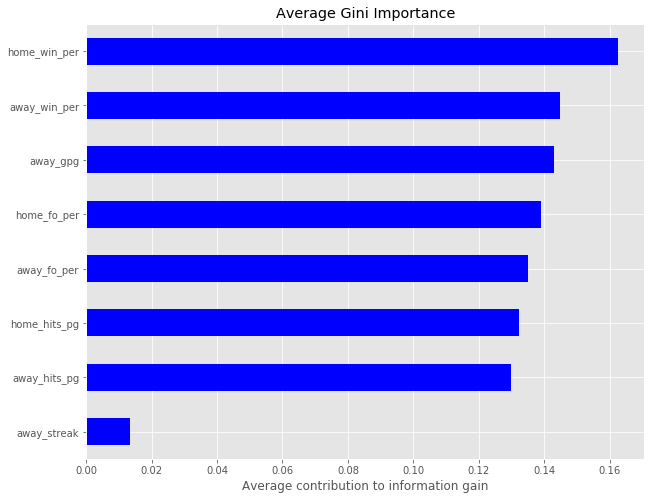

In [61]:
# Feature importances

feat_scores = pd.Series(rf.feature_importances_,
                           index=X3_train.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')

### **Gradient boost**

In [62]:
# GB with data minus time travel

gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
gb.fit(X2_train, y2_train)
gb.score(X2_test, y2_test)

0.5470444211262679

In [63]:
# GB with data containing fewer features

gb3 = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
gb3.fit(X3_train, y3_train)
gb3.score(X3_test, y3_test)

0.5442462399440364

### **Breakdown by season**

The previous modeling included stats from all seasons put together.  Will breakdown cumulative stats by season to see if it improves accuracy.

In [80]:
# Copy and merge dataframes to work with

season_df = game_df
season_team = team_game_df

season_team = pd.merge(season_team, season_df[['game_id', 'season']], on='game_id', how='left')

In [81]:
'''
Season dataframe names:
season_20112012
season_20122013
season_20132014
season_20142015
season_20152016
season_20162017
season_20172018
season_20182019
'''

'\nSeason dataframe names:\nseason_20112012\nseason_20122013\nseason_20132014\nseason_20142015\nseason_20152016\nseason_20162017\nseason_20172018\nseason_20182019\n'

##### **20112012**

In [82]:
# Create resective season df and merge home and away stats as before

season_20112012 = season_df[season_df.season == 20112012]
filtered = season_team[season_team.season == 20112012]

In [83]:
# now calc cumulative stats

filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [84]:
# Filter and merge home team stats

filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})

season_20112012 = season_20112012.merge(filtered_h, on='game_id', how='left')

In [85]:
# filter and merge away team stats

filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

season_20112012 = season_20112012.merge(filtered_a, on='game_id', how='left')

In [86]:
# Drop columns and change bools to 1/0

season_20112012 = season_20112012.drop(columns=['goal_spread', 'total_goals', 'season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20112012 = season_20112012.replace({'home_streak': False}, 0)
season_20112012 = season_20112012.replace({'home_streak': True}, 1)
season_20112012 = season_20112012.replace({'away_streak': False}, 0)
season_20112012 = season_20112012.replace({'away_streak': True}, 1)
season_20112012 = season_20112012.replace({'outcome': 'loss'}, 0)
season_20112012 = season_20112012.replace({'outcome': 'win'}, 1)

season_20112012 = season_20112012.fillna(0)

In [87]:
season_20112012

,away_team_id,home_team_id,outcome,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,home_hits_pg,home_pim_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,1,4,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,4,0,1.0,4.000000,1.000000,0.166667,36.000000,27.000000,6.000000,...,0.0,3.000000,0.000000,0.333333,26.000000,31.000000,12.000000,44.900000,6.000000,7.000000
2,4,1,1,1.0,3.500000,0.500000,0.142857,30.500000,31.500000,12.000000,...,0.0,2.500000,0.500000,0.090909,28.000000,25.500000,19.000000,52.100000,11.000000,5.000000
3,4,1,1,1.0,3.666667,0.666667,0.222222,30.666667,31.000000,11.333333,...,0.0,2.666667,0.333333,0.125000,28.000000,26.333333,14.000000,51.666667,8.000000,3.666667
4,1,4,0,0.0,2.500000,0.250000,0.166667,26.500000,25.500000,13.000000,...,1.0,3.750000,0.750000,0.214286,33.750000,28.000000,9.500000,45.625000,7.500000,5.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,19,23,0,0.0,2.895349,0.604651,0.195440,31.662791,22.732558,13.220930,...,0.0,2.477778,0.577778,0.168874,30.400000,24.366667,14.111111,50.476667,4.711111,6.011111
1312,5,20,0,0.0,2.419753,0.456790,0.178988,27.641975,19.481481,10.703704,...,1.0,3.372093,0.593023,0.203883,33.720930,25.720930,11.604651,50.409302,6.116279,5.290698
1313,6,4,0,0.0,3.230769,0.571429,0.212121,31.659341,25.747253,16.219780,...,1.0,3.068182,0.579545,0.164179,32.545455,23.068182,12.704545,54.155682,6.556818,5.522727
1314,4,5,1,1.0,3.390805,0.597701,0.207006,33.758621,25.609195,11.632184,...,0.0,3.250000,0.565217,0.215633,31.728261,25.891304,16.380435,48.679348,7.847826,5.728261


##### **2012-2013**

In [92]:
season_20122013 = season_df[season_df.season == 20122013]
filtered = season_team[season_team.season == 20122013]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20122013 = season_20122013.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20122013 = season_20122013.merge(filtered_a, on='game_id', how='left')

season_20122013 = season_20122013.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20122013 = season_20122013.replace({'home_streak': False}, 0)
season_20122013 = season_20122013.replace({'home_streak': True}, 1)
season_20122013 = season_20122013.replace({'away_streak': False}, 0)
season_20122013 = season_20122013.replace({'away_streak': True}, 1)
season_20122013 = season_20122013.replace({'outcome': 'loss'}, 0)
season_20122013 = season_20122013.replace({'outcome': 'win'}, 1)

season_20122013 = season_20122013.fillna(0)
season_20122013 = season_20122013.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [93]:
season_20122013

,away_team_id,home_team_id,outcome,goal_spread,total_goals,home_streak,home_gpg,home_win_per,home_ppg_per,home_shots_pg,...,away_streak,away_gpg,away_win_per,away_ppg_per,away_shots_pg,away_hits_pg,away_pim_pg,away_fo_per,away_giveaways_pg,away_takeaways_pg
0,3,6,1,1,5,1.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3,6,1,3,7,1.0,3.000000,1.000000,0.250000,48.000000,...,0.0,2.000000,0.000000,0.000000,35.000000,44.000000,8.000000,44.800000,17.000000,7.000000
2,6,3,0,1,3,0.0,2.000000,0.000000,0.000000,36.000000,...,1.0,4.000000,1.000000,0.200000,40.000000,43.500000,12.500000,51.750000,10.000000,5.500000
3,6,3,1,1,7,0.0,1.666667,0.000000,0.000000,32.000000,...,1.0,3.333333,1.000000,0.200000,38.000000,38.333333,10.333333,55.100000,10.000000,6.000000
4,3,6,1,2,4,0.0,3.250000,0.750000,0.333333,38.500000,...,1.0,2.250000,0.250000,0.071429,32.000000,38.500000,7.250000,45.250000,8.500000,6.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,23,19,1,1,3,1.0,2.557692,0.576923,0.193750,27.769231,...,0.0,2.529412,0.509804,0.156977,28.549020,22.450980,12.921569,47.427451,7.470588,6.862745
802,19,21,1,1,1,1.0,2.404255,0.319149,0.151079,29.680851,...,1.0,2.528302,0.584906,0.189024,27.924528,25.301887,10.735849,50.745283,5.018868,5.886792
803,20,27,1,4,4,0.0,2.489362,0.425532,0.148810,30.765957,...,1.0,2.723404,0.404255,0.201299,26.872340,19.021277,10.872340,46.951064,8.829787,7.191489
804,26,16,1,1,5,1.0,3.000000,0.728571,0.148837,32.057143,...,0.0,2.553846,0.553846,0.186916,28.676923,33.353846,9.400000,51.089231,8.876923,4.815385


##### **2013-2014**

In [94]:
season_20132014 = season_df[season_df.season == 20132014]
filtered = season_team[season_team.season == 20132014]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20132014 = season_20132014.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20132014 = season_20132014.merge(filtered_a, on='game_id', how='left')

season_20132014 = season_20132014.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20132014 = season_20132014.replace({'home_streak': False}, 0)
season_20132014 = season_20132014.replace({'home_streak': True}, 1)
season_20132014 = season_20132014.replace({'away_streak': False}, 0)
season_20132014 = season_20132014.replace({'away_streak': True}, 1)
season_20132014 = season_20132014.replace({'outcome': 'loss'}, 0)
season_20132014 = season_20132014.replace({'outcome': 'win'}, 1)
season_20132014 = season_20132014.fillna(0)
season_20132014 = season_20132014.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

##### **2014-2015**

In [95]:
season_20142015 = season_df[season_df.season == 20142015]
filtered = season_team[season_team.season == 20142015]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20142015 = season_20142015.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20142015 = season_20142015.merge(filtered_a, on='game_id', how='left')

season_20142015 = season_20142015.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20142015 = season_20142015.replace({'home_streak': False}, 0)
season_20142015 = season_20142015.replace({'home_streak': True}, 1)
season_20142015 = season_20142015.replace({'away_streak': False}, 0)
season_20142015 = season_20142015.replace({'away_streak': True}, 1)
season_20142015 = season_20142015.replace({'outcome': 'loss'}, 0)
season_20142015 = season_20142015.replace({'outcome': 'win'}, 1)
season_20142015 = season_20142015.fillna(0)

season_20142015 = season_20142015.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

##### **2015-2016**

In [96]:
season_20152016 = season_df[season_df.season == 20152016]
filtered = season_team[season_team.season == 20152016]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20152016 = season_20152016.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20152016 = season_20152016.merge(filtered_a, on='game_id', how='left')

season_20152016 = season_20152016.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20152016 = season_20152016.replace({'home_streak': False}, 0)
season_20152016 = season_20152016.replace({'home_streak': True}, 1)
season_20152016 = season_20152016.replace({'away_streak': False}, 0)
season_20152016 = season_20152016.replace({'away_streak': True}, 1)
season_20152016 = season_20152016.replace({'outcome': 'loss'}, 0)
season_20152016 = season_20152016.replace({'outcome': 'win'}, 1)
season_20152016 = season_20152016.fillna(0)

season_20152016 = season_20152016.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

##### **2016-2017**

In [97]:
season_20162017 = season_df[season_df.season == 20162017]
filtered = season_team[season_team.season == 20162017]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20162017 = season_20162017.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20162017 = season_20162017.merge(filtered_a, on='game_id', how='left')

season_20162017 = season_20162017.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20162017 = season_20162017.replace({'home_streak': False}, 0)
season_20162017 = season_20162017.replace({'home_streak': True}, 1)
season_20162017 = season_20162017.replace({'away_streak': False}, 0)
season_20162017 = season_20162017.replace({'away_streak': True}, 1)
season_20162017 = season_20162017.replace({'outcome': 'loss'}, 0)
season_20162017 = season_20162017.replace({'outcome': 'win'}, 1)
season_20162017 = season_20162017.fillna(0)

season_20162017 = season_20162017.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

##### **2017-2018**

In [98]:
season_20172018 = season_df[season_df.season == 20172018]
filtered = season_team[season_team.season == 20172018]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20172018 = season_20172018.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20172018 = season_20172018.merge(filtered_a, on='game_id', how='left')

season_20172018 = season_20172018.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20172018 = season_20172018.replace({'home_streak': False}, 0)
season_20172018 = season_20172018.replace({'home_streak': True}, 1)
season_20172018 = season_20172018.replace({'away_streak': False}, 0)
season_20172018 = season_20172018.replace({'away_streak': True}, 1)
season_20172018 = season_20172018.replace({'outcome': 'loss'}, 0)
season_20172018 = season_20172018.replace({'outcome': 'win'}, 1)

season_20172018 = season_20172018.fillna(0)

season_20172018 = season_20172018.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

##### **2018-2019**

In [99]:
season_20182019 = season_df[season_df.season == 20182019]
filtered = season_team[season_team.season == 20182019]

# now calc cumulative stats
filtered['gpg'] = (filtered.groupby('team_id')['goals'].cumsum() - filtered['goals']) / filtered.groupby('team_id').cumcount()
filtered['win_per'] = (filtered.groupby('team_id')['won'].cumsum() - filtered['won']) / filtered.groupby('team_id').cumcount()
filtered['shots_pg'] = (filtered.groupby('team_id')['shots'].cumsum() - filtered['shots']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['pim_pg'] = (filtered.groupby('team_id')['pim'].cumsum() - filtered['pim']) / filtered.groupby('team_id').cumcount()
filtered['hits_pg'] = (filtered.groupby('team_id')['hits'].cumsum() - filtered['hits']) / filtered.groupby('team_id').cumcount()
filtered['fo_per'] = (filtered.groupby('team_id')['faceOffWinPercentage'].cumsum() - filtered['faceOffWinPercentage']) / filtered.groupby('team_id').cumcount()
filtered['giveaways_pg'] = (filtered.groupby('team_id')['giveaways'].cumsum() - filtered['giveaways']) / filtered.groupby('team_id').cumcount()
filtered['takeaways_pg'] = (filtered.groupby('team_id')['takeaways'].cumsum() - filtered['takeaways']) / filtered.groupby('team_id').cumcount()
filtered['ppg_per'] = ((filtered.groupby('team_id')['powerPlayGoals'].cumsum() - filtered['powerPlayGoals'])) / ((filtered.groupby('team_id')['powerPlayOpportunities'].cumsum() - filtered['powerPlayOpportunities']))

# filter home team stats
filtered_h = filtered[filtered.HoA == 'home']
filtered_h = filtered_h.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_h = filtered_h.rename(columns={'streak': 'home_streak', 'time_travel': 'home_time_travel', 'gpg': 'home_gpg', "win_per": "home_win_per", "ppg_per": "home_ppg_per", 'shots_pg': 'home_shots_pg', 'hits_pg': 'home_hits_pg', 'pim_pg': 'home_pim_pg', 'fo_per': 'home_fo_per', 'giveaways_pg': 'home_giveaways_pg',
       'takeaways_pg': 'home_takeaways_pg'})
# merge home team stats
season_20182019 = season_20182019.merge(filtered_h, on='game_id', how='left')

# filter away team stats
filtered_a = filtered[filtered.HoA == 'away']
filtered_a = filtered_a.filter(items=['game_id', 'season', 'streak', 'time_travel', 'gpg', 'win_per', 'ppg_per', 'shots_pg', 'hits_pg', 'pim_pg', 'fo_per', 'giveaways_pg', 'takeaways_pg'])
filtered_a = filtered_a.rename(columns={'streak': 'away_streak', 'time_travel': 'away_time_travel', 'gpg': 'away_gpg', "win_per": "away_win_per", "ppg_per": "away_ppg_per", 'shots_pg': 'away_shots_pg', 'hits_pg': 'away_hits_pg', 'pim_pg': 'away_pim_pg', 'fo_per': 'away_fo_per', 'giveaways_pg': 'away_giveaways_pg',
       'takeaways_pg': 'away_takeaways_pg'})

# merge away team stats
season_20182019 = season_20182019.merge(filtered_a, on='game_id', how='left')

season_20182019 = season_20182019.drop(columns=['season_x', 'season_y', 'game_id', 'type', 'date_time', 'date_time_GMT'])
season_20182019 = season_20182019.replace({'home_streak': False}, 0)
season_20182019 = season_20182019.replace({'home_streak': True}, 1)
season_20182019 = season_20182019.replace({'away_streak': False}, 0)
season_20182019 = season_20182019.replace({'away_streak': True}, 1)
season_20182019 = season_20182019.replace({'outcome': 'loss'}, 0)
season_20182019 = season_20182019.replace({'outcome': 'win'}, 1)
season_20182019 = season_20182019.fillna(0)

season_20182019 = season_20182019.drop(labels=['season'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

* Below are the dataframes containing data only for each season

In [100]:
df_list = [season_20112012,
           season_20122013,
           season_20132014,
           season_20142015,
           season_20152016,
           season_20162017,
           season_20172018,
           season_20182019]

In [101]:
season_names = ['s_20112012',
                's_20122013',
                's_20132014',
                's_20142015',
                's_20152016',
                's_20162017',
                's_20172018',
                's_20182019']

## **Models**

##### **Logistic Regression**

In [102]:
# Logistic Regression with K-Fold Cross-Validation

log_reg = []
for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    logr_scores = []

    model_kf = LogisticRegression()
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_kf.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        logr_scores.append(model_kf.score(X_train.values[test], y_train.values[test]))
    
    log_reg.append(np.mean(logr_scores))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [103]:
# Accuracy for each season

log_reg_acc = {}
for k, v in zip(season_names, log_reg):
    log_reg_acc[k] = v
    
log_reg_acc

{'s_20112012': 0.5622878531507973,
 's_20122013': 0.5745179063360882,
 's_20132014': 0.5624892137454951,
 's_20142015': 0.5409372916987131,
 's_20152016': 0.5313131313131313,
 's_20162017': 0.5389324719273958,
 's_20172018': 0.5708731768569497,
 's_20182019': 0.5343861682604076}

In [104]:
# P-values for the individual features

logit_pvalue(model_kf, X_train)

pvals = {}
for feat, pval in zip(list(X_train.columns), logit_pvalue(model_kf, X_train)):
    pvals[feat] = pval

print(betas2)
pvals

{'away_team_id': 0.0024483241139516237, 'home_team_id': -0.0002123379155126861, 'goal_spread': 0.11778838271147228, 'total_goals': 0.013019577348397223, 'home_streak': -0.04782089532991535, 'home_gpg': 0.0190907261213392, 'home_win_per': 0.39936093206214096, 'home_ppg_per': 0.15736157763683936, 'home_shots_pg': 0.0398070527806266, 'home_hits_pg': 0.016065334911097517, 'home_pim_pg': 0.0022031429069358744, 'home_fo_per': -0.025743741272660665, 'home_giveaways_pg': 0.001738253698391103, 'home_takeaways_pg': -0.0038693748182243295, 'away_streak': -0.031868382921486166, 'away_gpg': 0.04600526091668979, 'away_win_per': -0.0008062300799518117, 'away_ppg_per': -0.3931470014804633, 'away_shots_pg': -0.15590151083575682, 'away_hits_pg': -0.03263389133153694, 'away_pim_pg': -0.0416356634103675, 'away_fo_per': -0.0019002757876353685, 'away_giveaways_pg': 0.03713117244567162, 'away_takeaways_pg': 0.0035227028533132304}


{'away_team_id': 0.9709451320021911,
 'home_team_id': 0.11222762709314704,
 'goal_spread': 0.6350932997372176,
 'total_goals': 0.02501598087472079,
 'home_streak': 0.1326342986833129,
 'home_gpg': 0.4020145002413795,
 'home_win_per': 0.6623416996690683,
 'home_ppg_per': 0.7825143773490773,
 'home_shots_pg': 0.9196558410089026,
 'home_hits_pg': 0.2911899606820323,
 'home_pim_pg': 0.8632724435731756,
 'home_fo_per': 0.0397187371653398,
 'home_giveaways_pg': 0.80019864401328,
 'home_takeaways_pg': 0.6265074446148071,
 'away_streak': 0.0332510156164294,
 'away_gpg': 0.9707896534475349,
 'away_win_per': 0.3145440806915203,
 'away_ppg_per': 0.7219112105099987,
 'away_shots_pg': 0.957789772354156,
 'away_hits_pg': 0.6162677069818137,
 'away_pim_pg': 0.09129789958787149,
 'away_fo_per': 0.08766048933429338,
 'away_giveaways_pg': 0.04084474239291347,
 'away_takeaways_pg': 0.13113850791255244}

##### **Random Forest**

In [105]:
# Random Forest with K-Fold Cross-Validation

rand_for = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    rf_scores = []

    model_rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_rf.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        rf_scores.append(model_rf.score(X_train.values[test], y_train.values[test]))
    
    rand_for.append(np.mean(rf_scores))

In [106]:
# Accuracy for each season

rf_acc = {}
for k, v in zip(season_names, rand_for):
    rf_acc[k] = v
    
rf_acc

{'s_20112012': 0.5177511152130442,
 's_20122013': 0.5397382920110193,
 's_20132014': 0.5282320694380995,
 's_20142015': 0.5550992155053069,
 's_20152016': 0.5424242424242425,
 's_20162017': 0.5572014561862277,
 's_20172018': 0.5964744518497055,
 's_20182019': 0.5618709552786633}

In [107]:
# OOB scores

rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=9)
rf_oob = []

for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    rf.fit(X_train, y_train)
    rf_oob.append(rf.oob_score_)

oob_scores = {}
for k, v in zip(season_names, rf_oob):
    oob_scores[k] = v
oob_scores

{'s_20112012': 0.5298885511651469,
 's_20122013': 0.5596026490066225,
 's_20132014': 0.532258064516129,
 's_20142015': 0.5409504550050556,
 's_20152016': 0.5343434343434343,
 's_20162017': 0.5612968591691996,
 's_20172018': 0.5875984251968503,
 's_20182019': 0.5343811394891945}

##### **Gradient Boosting**

In [108]:
grad_boo = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    gb_scores = []

    model_gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        model_gb.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        gb_scores.append(model_gb.score(X_train.values[test], y_train.values[test]))
    
    grad_boo.append(np.mean(gb_scores))

In [109]:
gb_acc = {}
for k, v in zip(season_names, grad_boo):
    gb_acc[k] = v
    
gb_acc

{'s_20112012': 0.5421268522791365,
 's_20122013': 0.5215151515151515,
 's_20132014': 0.5443124714481499,
 's_20142015': 0.551043429216018,
 's_20152016': 0.5606060606060606,
 's_20162017': 0.561370045634005,
 's_20172018': 0.5826765188834154,
 's_20182019': 0.5422148169612673}

In [110]:
gb = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)

gb_score = []

for df in df_list:
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    gb.fit(X_train, y_train)
    gb_score.append(gb.score(X_test, y_test))

gb_scores_nocv = {}
for k, v in zip(season_names, gb_score):
    gb_scores_nocv[k] = v
gb_scores_nocv

{'s_20112012': 0.5562310030395137,
 's_20122013': 0.5792079207920792,
 's_20132014': 0.5589123867069486,
 's_20142015': 0.5636363636363636,
 's_20152016': 0.513595166163142,
 's_20162017': 0.5424242424242425,
 's_20172018': 0.5103244837758112,
 's_20182019': 0.5264705882352941}

In [ ]:
# Variable name tracker:
'''
Cross-val log reg:      log_reg_acc
Cross-val rand forest:  rf_acc
Cross-val grad boost:   gb_acc

Rand forest oob:        oob_scores
Grad boos no cross val: gb_scores_nocv
'''

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

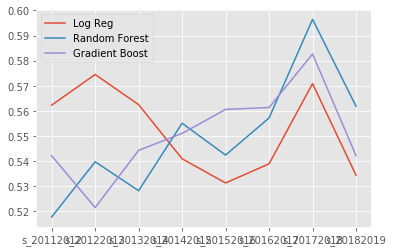

In [111]:
# Plot performance of the 3 models and their cross-val scores:
plt.plot(season_names, log_reg, label='Log Reg') 
plt.plot(season_names, rand_for, label='Random Forest')
plt.plot(season_names, grad_boo, label='Gradient Boost')
plt.legend()
plt.xlabel

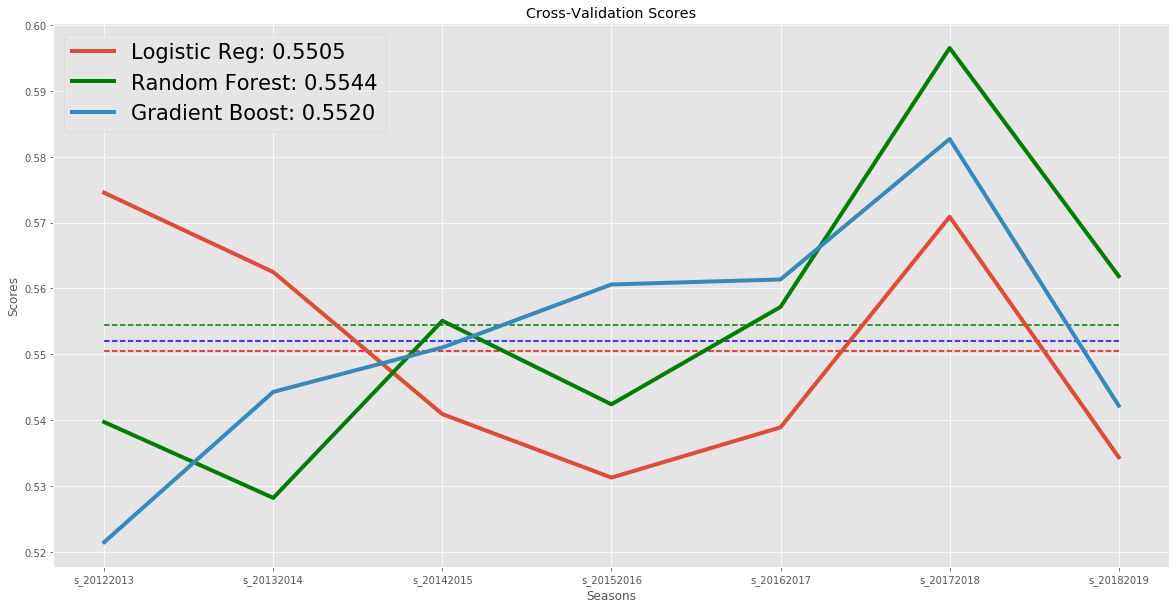

In [112]:
fig = plt.figure(figsize=(20,10))
plt.plot(season_names[1:], log_reg[1:], linewidth=4, label=f'Logistic Reg: {np.mean(log_reg[1:]):.4f}') 
plt.plot(season_names[1:], rand_for[1:], linewidth=4, color='green', label=f'Random Forest: {np.mean(rand_for[1:]):.4f}')
plt.plot(season_names[1:], grad_boo[1:], linewidth=4, label=f'Gradient Boost: {np.mean(grad_boo[1:]):.4f}')
plt.legend(prop={'size': 21})
plt.xlabel('Seasons')
plt.ylabel('Scores')
plt.title('Cross-Validation Scores')
plt.hlines((np.mean(log_reg[1:])), season_names[1:], season_names[-1:], colors='r', linestyles='dashed')
plt.hlines((np.mean(rand_for[1:])), season_names[1:], season_names[-1:], colors='green', linestyles='dashed')
plt.hlines((np.mean(grad_boo[1:])), season_names[1:], season_names[-1:], colors='blue', linestyles='dashed')
# plt.savefig('Cross_val_all_season_train')

* Eliminated the first season (2011-2012) for now.  Need to look into why its accuracy was unusually high.
* According to the chart, GB performed best in 2 seasons, RF best in 2 seasons, LR best in 2 seasons.

## **Train Model on 1 season**

In [ ]:
'''
How will training model on only one season perform when predicting others?

Objectives:
    -Use 2016-2017 season since all 3 models were fairly close for that one.  Maybe 2014-2015.
        'season_20162017'
    -Random Forest - with random search
    -Gradient Boost - with random search?
    -Deep Learning
    
Later:
    -Regression for goal spread?
    -Add in player stats?
'''

In [113]:
X4 = season_20162017.drop(labels=['outcome'], axis=1)
y4 = season_20162017.outcome

In [114]:
# Train-test-split:
X4_train, X4_test, y4_train, y4_test = cv.train_test_split(X4, y4, test_size=0.2, random_state=1)

# Train-test-split again to create validation set:
X4_train, X4_val, y4_train, y4_val = cv.train_test_split(X4_train, y4_train, test_size=0.2, random_state=1)

##### **Random Forest with Grid Search**

In [115]:
# Random forest with grid search to optimize parameters

rf2 = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True, max_depth=10)

parameters = {'n_estimators': [100, 250, 500, 750, 1000],
              #'criterion': ['mse'],
              'max_depth': [5, 10, 15], 
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 3, 5]
             }

grid_obj = GridSearchCV(rf2, parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_obj = grid_obj.fit(X4_train, y4_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.5min finished


In [116]:
rf2 = grid_obj.best_estimator_
rf2.fit(X4_train, y4_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=250,
                       oob_score=True, random_state=0)

In [118]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = rf2.predict(X4_val)
y_validation_RF = y4_val.reset_index()['outcome']

print('R2 score = ',r2_score(y_validation_RF, predictions), '/ 1.0')
print('MSE score = ',mean_squared_error(y_validation_RF, predictions), '/ 0.0')

R2 score =  -0.8572595281306714 / 1.0
MSE score =  0.4597156398104265 / 0.0


In [119]:
# test data predictions
predictions = rf2.predict(X4_test)

y_test_RF = y4_test.reset_index()['outcome']

print('R2 score = ',r2_score(y_test_RF, predictions), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test_RF, predictions), '/ 0.0')

R2 score =  -0.8026954177897572 / 1.0
MSE score =  0.4318181818181818 / 0.0


In [120]:
rf2.score(X4_test, y4_test)

0.5681818181818182

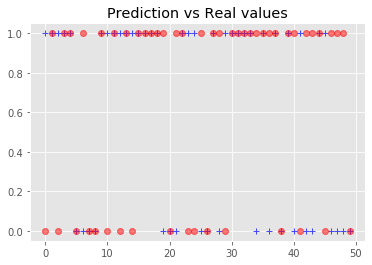

In [121]:
plt.plot(y_validation_RF[0:50], '+', color ='blue', alpha=0.7)
plt.plot(predictions[0:50], 'ro', color ='red', alpha=0.5)
plt.title('Prediction vs Real values')
plt.show()

##### **Gradient Boost with Grid Search**

In [122]:
gb2 = GradientBoostingClassifier(loss='deviance',
                                   learning_rate=0.005,
                                   n_estimators=500,
                                   min_samples_leaf=5)

parameters_gb = {'learning_rate': [.001, .005, .01, .015, .02],
              #'criterion': ['mse'],
              'n_estimators': [10, 50, 100, 250, 500, 1000],
              'max_depth': [3, 5, 10], 
              'min_samples_split': [2, 5, 7, 10],
              'min_samples_leaf': [1, 3, 5]
             }

grid_obj_gb = GridSearchCV(gb2, parameters_gb,
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_obj_gb = grid_obj_gb.fit(X4_train, y4_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 54.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 98.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 103.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 107.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 112.5min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 116.4min finished


In [123]:
gb2 = grid_obj_gb.best_estimator_
gb2.fit(X4_train, y4_train)

GradientBoostingClassifier(learning_rate=0.015, max_depth=10, n_estimators=500)

In [124]:
predictions_gb = gb2.predict(X4_val)
y_validation_gb = y4_val.reset_index()['outcome']

print('R2 score = ',r2_score(y_validation_gb, predictions_gb), '/ 1.0')
print('MSE score = ',mean_squared_error(y_validation_gb, predictions_gb), '/ 0.0')

R2 score =  -0.9529945553539019 / 1.0
MSE score =  0.4834123222748815 / 0.0


In [127]:
# test data predictions
predictions_gb = gb2.predict(X4_test)

y4_test_gb = y4_test.reset_index()['outcome']

print('R2 score = ',r2_score(y4_test_gb, predictions_gb), '/ 1.0')
print('MSE score = ',mean_squared_error(y4_test_gb, predictions_gb), '/ 0.0')

R2 score =  -0.7552560646900266 / 1.0
MSE score =  0.42045454545454547 / 0.0


In [128]:
gb2.score(X4_test, y4_test)

0.5795454545454546

##### **Use the RF and GB models to predict other seasons**

In [129]:
rand_for2 = []
rf_scores2 = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    rf_scores = []
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        rf2.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        rf_scores.append(rf2.score(X_train.values[test], y_train.values[test]))
    rf_scores2.append(rf2.score(X_test, y_test))
    rand_for2.append(np.mean(rf_scores))

In [130]:
rf_acc2 = {}
for k, v in zip(season_names, rand_for2):
    rf_acc2[k] = v
    
rf_acc2

{'s_20112012': 0.5249192431933548,
 's_20122013': 0.5711707988980717,
 's_20132014': 0.5342723719608141,
 's_20142015': 0.5490591191098805,
 's_20152016': 0.5515151515151515,
 's_20162017': 0.5471260831666923,
 's_20172018': 0.6053028107794842,
 's_20182019': 0.5354293441514537}

In [131]:
predict_scores_rf = {}
for k, v in zip(season_names, rf_scores2):
    predict_scores_rf[k] = v
    
predict_scores_rf

{'s_20112012': 0.5045592705167173,
 's_20122013': 0.5792079207920792,
 's_20132014': 0.5226586102719033,
 's_20142015': 0.5727272727272728,
 's_20152016': 0.5287009063444109,
 's_20162017': 0.5787878787878787,
 's_20172018': 0.5486725663716814,
 's_20182019': 0.5205882352941177}

In [132]:
grad_boo2 = []
gb_scores2 = []
for df in df_list: 
    X = df.drop(labels=['outcome'], axis=1)
    y = df.outcome
    
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=1)
    
    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    gb_scores = []
    
    for train, test in kf.split(X_train):
        ## fit the model to training data
        gb2.fit(X_train.values[train], y_train.values[train])
        ## evaluate the model on testing data!!!
        gb_scores.append(gb2.score(X_train.values[test], y_train.values[test]))
    gb_scores2.append(gb2.score(X_test, y_test))
    grad_boo2.append(np.mean(gb_scores))

In [133]:
gb_acc2 = {}
for k, v in zip(season_names, grad_boo2):
    gb_acc2[k] = v
    
gb_acc2

{'s_20112012': 0.5014664410603497,
 's_20122013': 0.4966666666666667,
 's_20132014': 0.5443276991015684,
 's_20142015': 0.5419422652925191,
 's_20152016': 0.5484848484848485,
 's_20162017': 0.5328667384504948,
 's_20172018': 0.5699024437361151,
 's_20182019': 0.512759586593258}

In [134]:
predict_scores_gb = {}
for k, v in zip(season_names, gb_scores2):
    predict_scores_gb[k] = v
    
predict_scores_gb

{'s_20112012': 0.513677811550152,
 's_20122013': 0.5247524752475248,
 's_20132014': 0.5589123867069486,
 's_20142015': 0.5454545454545454,
 's_20152016': 0.5317220543806647,
 's_20162017': 0.5757575757575758,
 's_20172018': 0.5545722713864307,
 's_20182019': 0.49117647058823527}

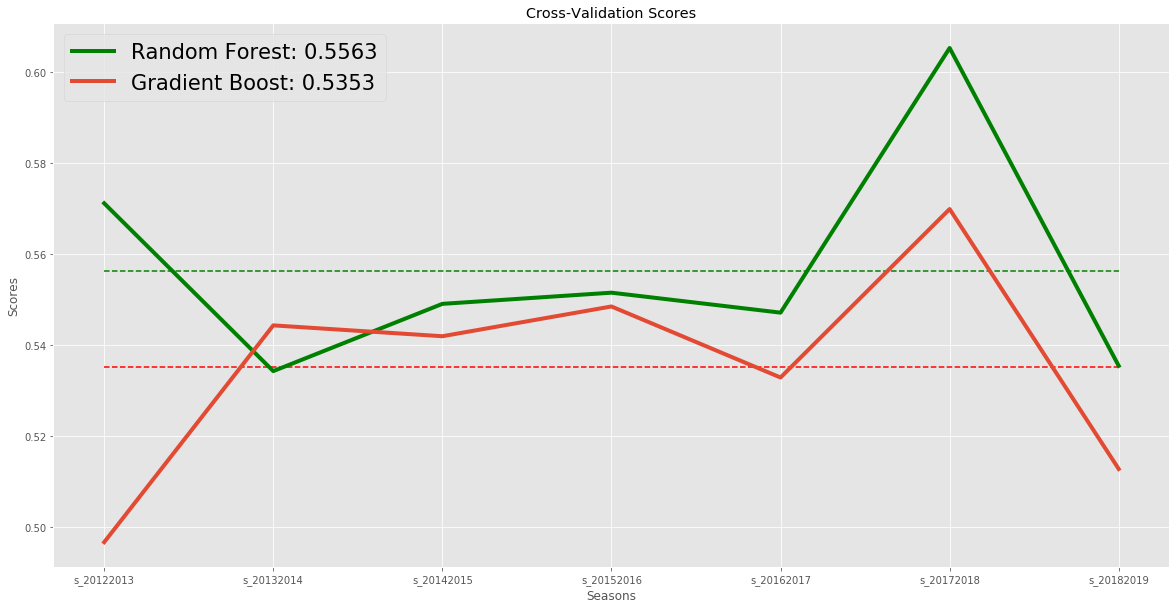

In [135]:
fig = plt.figure(figsize=(20,10))
plt.plot(season_names[1:], rand_for2[1:], linewidth=4, color='green', label=f'Random Forest: {np.mean(rand_for2[1:]):.4f}')
plt.plot(season_names[1:], grad_boo2[1:], linewidth=4, label=f'Gradient Boost: {np.mean(grad_boo2[1:]):.4f}')
plt.legend(prop={'size': 21})
plt.xlabel('Seasons')
plt.ylabel('Scores')
plt.title('Cross-Validation Scores')
plt.hlines((np.mean(rand_for2[1:])), season_names[1:], season_names[-1:], colors='green', linestyles='dashed')
plt.hlines((np.mean(grad_boo2[1:])), season_names[1:], season_names[-1:], colors='red', linestyles='dashed')
# plt.savefig('one_season_training')

##### **Tensorflow (COME BACK TO LATER)**
* from: https://www.kaggle.com/kyubii/nba-deep-learning-2-2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [ ]:
model = Sequential()

In [ ]:
# Building the model
model.add(Dense(200, input_dim=50, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

In [ ]:
# Convert data as np.array
X5 = df.drop(labels=['outcome'], axis=1)
y5 = df.outcome
    
X5_train, X5_test, y5_train, y5_test = cv.train_test_split(X5, y5, test_size=0.25, random_state=1)

features = np.array(X5_train)
targets = np.array(y5_train)

features_validation= np.array(X5_val)
targets_validation = np.array(y5_val)

features_test= np.array(X5_test)
targets_test = np.array(y5_test)

In [ ]:
print(features.shape)
print(targets.shape)

In [ ]:
model.fit(features, targets, epochs=10, batch_size=24)

In [ ]:
# Training the model

'''GETTING AN ERROR HERE'''

epochs_tot = 1000
epochs_step = 100
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mse'])), axis = 0)
    
# plot metrics
plt.plot(hist)
plt.show()

## **Betting**

-Correct: 55%
-https://www.vegasinsider.com/nhl/odds/las-vegas/
  EDMONTON -160 (BET $100 TO WIN $62.50)
  ARIZONA +145 (BET $100 TO WIN $145)
  
Favorite:               Underdog:
-If correct: +62.50     -If correct: +145
-If wrong: -100         -If wrong: -100

In [ ]:
print('Gain/Loss for Favorite: ', (55 * 62.50) - (45 * 100))
print('Gain/Loss for Underdog: ', (45 * 145) - (55 * 100))

* According to https://www.oddsshark.com/sports-betting/which-sport-do-betting-underdogs-win-most-often,
  NHL underdogs win approximately 41% of the time.

In [ ]:
print('Gain/Loss for Favorite: ', (61.5 * 62.50) - (38.5 * 100))
print('Gain/Loss for Underdog: ', (41 * 145) - (59 * 100))

#### *To break even, you need to be right about 61.5% of the time.*

In [ ]:
from random import choices

In [ ]:
population = [0, 1]
weights = [0.45, 0.55]
num_bets = 100

def bet_sim(population, weights, num_bets):
    money = 0
    wins = []
    for i in range(num_bets):
        wins.append(choices(population, weights))
    
    for _ in wins:
        for win in _:
            if win == 0:
                money -= 100
            else:
                money += 62.5
    return money

bet_sim(population, weights, num_bets)

In [ ]:
winnings = []
for i in range(100):
    winnings.append(bet_sim(population, weights, num_bets))
np.mean(winnings)

In [ ]:
nums = [.5900350, .5917832, .5847902, .5900350, .5839161, .5821678, .5865385, .6031469, .5970280, .5900350, .5882867, .5882867, .5743007, .5952797, .5847902, .5926573, .5900350]
np.mean(nums)